# 🤖 Checkpoint 5 - ML for CV: U-Net Architecture Design

## 📌 Goal  
You are given a dataset of images.  
Your task is to **design and train custom U-Nets (at least 3 versions)** on a given dataset, then compare their performance.  

This assignment will help you practice **model training in Colab, experimenting with CNN architectures, and interpreting results**.



# U-Net Training

Before you jump in, I highly recommend you watch this video on UNets to understand how they are an extension of CNNs, how they actually work, and what they might be useful for.

YouTube: https://www.youtube.com/watch?v=NhdzGfB1q74

Make sure you are connected to the T4 GPU runtime. Click on `Connect` on the top right. If you don't see that, click the downward arrow next to the resources where you see `RAM` and `Disk`. Then, click `Change runtime type` and select T4 GPU as the hardware accelerator. This will be necessary for training the models below!

If you're unsure which runtime is set up, reach out to Pranav.

In [19]:
!pip install opencv-python

## Step 0: Import Required Libraries

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

## Step 1: Mount your G Drive and access the videos

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, use the file explorer on the left to find the path to the image data and corresponding labels for this task.

They should be in your UMARV Shared Drive called `STUDENT-Robotics | UMARV` at `2025-2026/CV Onboarding`

In [22]:
# TODO
images_path = '/content/drive/Shareddrives/STUDENT-Robotics | UMARV/2025-2026/CV Onboarding/Images - Drivable Area/data'
labels_path = '/content/drive/Shareddrives/STUDENT-Robotics | UMARV/2025-2026/CV Onboarding/Labels - Drivable Area/drivable_area'

## Step 2: Initialize U-Net

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, use_dropout=False, use_residual=False):
        """
        UNet Baseline
        """
        super(UNet, self).__init__()

        # TODO: Toggle these parameters at the model initialization in the cell below
        self.use_dropout = use_dropout
        self.use_residual = use_residual

        # Encoder (only 1 block)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # TODO: Add more blocks, change number of filters

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (only 1 block)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        # TODO: Add more blocks matching encoder depth

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Conv block with optional dropout."""
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if self.use_dropout:
            # TODO: Modify chance of dropout
            layers.append(nn.Dropout(0.3))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        # TODO: Modify this part according to the architecture changes you made above

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder
        # TODO: Modify this part according to the architecture changes you made above
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        out = self.final_conv(dec1)

        # Optional residual
        if self.use_residual:
            out = out + F.interpolate(x[:, :out.shape[1], :, :], size=out.shape[2:], mode="bilinear")

        return out


In [24]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1, use_dropout=True, use_residual=True)   # 3 input channels (RGB), 1 output mask
model = model.to(device)

print("U-Net Initialized!")

U-Net Initialized!


## Step 3: Prepare Dataset for Training

You may want to increase the data we're training the UNet with. That can be controlled in the cell below in the initialization:

```python
dataset = SegmentationDataset(
    images_path,
    labels_path,
    transform=transform,
    subset_fraction=0.2  # <-----
)
```

Training samples: 798, Validation samples: 200
Visualizing images from the train set:


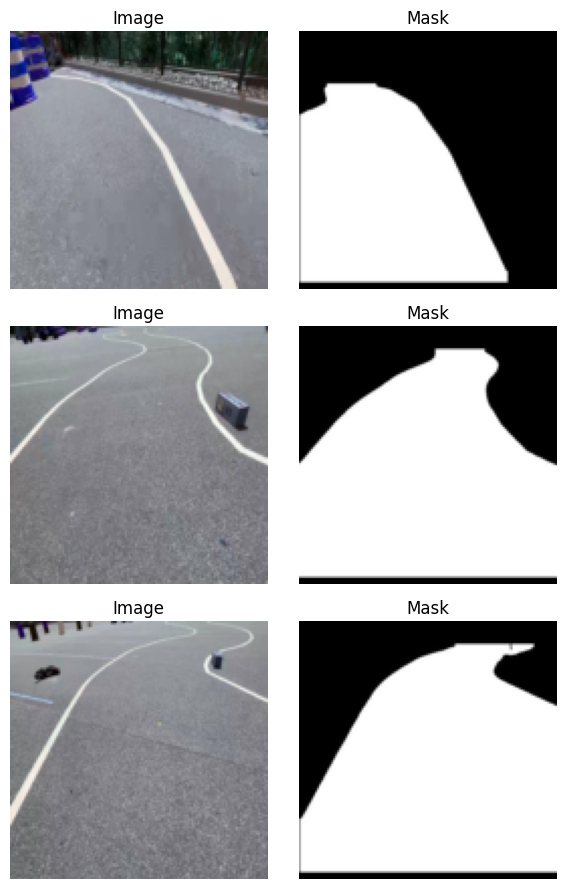

In [25]:
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, subset_fraction=1.0, seed=42):
        """
        images_path: path to folder with images
        labels_path: path to folder with masks
        transform: torchvision transforms to apply
        subset_fraction: fraction of dataset to use (e.g. 0.2 for 1/5 of data)
        seed: random seed for reproducibility
        """
        self.images = sorted(os.listdir(images_path))
        self.labels = sorted(os.listdir(labels_path))
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform

        # 🔹 Subsample dataset if subset_fraction < 1.0
        if subset_fraction < 1.0:
            random.seed(seed)
            total_size = len(self.images)
            subset_size = int(total_size * subset_fraction)
            indices = random.sample(range(total_size), subset_size)

            self.images = [self.images[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_path, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.labels_path, self.labels[idx])).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = SegmentationDataset(
    images_path,
    labels_path,
    transform=transform,
    subset_fraction=0.4  # TODO: Increase the data we are training the model with!
)

# 🔹 Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}")
print("Visualizing images from the train set:")

# 🔹 Visualize 3 samples
fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for i, (img, mask) in enumerate([train_set[j] for j in range(3)]):
    axes[i, 0].imshow(img.permute(1, 2, 0))
    axes[i, 1].imshow(mask.squeeze(), cmap="gray")
    for ax, title in zip(axes[i], ["Image", "Mask"]):
        ax.set_title(title); ax.axis("off")
plt.tight_layout(); plt.show()

## Step 4: Training Loop

Link to PyTorch Loss Function docs: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

In [37]:
import torch.optim as optim
from tqdm import tqdm

# 🔹 Define loss & optimizer
# TODO: Identify which loss function to use
# Hint: Your model predicts whether each pixel belongs to the object (foreground) or not (background).
# So at every pixel, you want to compare a probability (from the model) with a binary ground-truth label (0 or 1).
# Check the PyTorch loss functions docs (linked above) and pick the one designed for binary classification with raw logits (not probabilities).
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # 🔹 Training loop
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # TODO: Move imgs and masks to device
        imgs, masks = imgs.to(device), masks.to(device)

        # TODO: Forward pass
        outputs = model(imgs)

        # TODO: Compute loss
        loss = criterion(outputs, masks)

        # TODO: Zero gradients
        optimizer.zero_grad()

        # TODO: Backward pass
        loss.backward()

        # TODO: Optimizer step
        optimizer.step()

        running_loss += loss.item()

    # TODO: Compute average loss and print
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/20: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 1/20, Loss: 0.0417


Epoch 2/20: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 2/20, Loss: 0.0284


Epoch 3/20: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 3/20, Loss: 0.0299


Epoch 4/20: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 4/20, Loss: 0.0330


Epoch 5/20: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 5/20, Loss: 0.0268


Epoch 6/20: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 6/20, Loss: 0.0260


Epoch 7/20: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 7/20, Loss: 0.0253


Epoch 8/20: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Epoch 8/20, Loss: 0.0249


Epoch 9/20: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 9/20, Loss: 0.0247


Epoch 10/20: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 10/20, Loss: 0.0243


Epoch 11/20: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 11/20, Loss: 0.0759


Epoch 12/20: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 12/20, Loss: 0.0423


Epoch 13/20: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 13/20, Loss: 0.0349


Epoch 14/20: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Epoch 14/20, Loss: 0.0287


Epoch 15/20: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Epoch 15/20, Loss: 0.0267


Epoch 16/20: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


Epoch 16/20, Loss: 0.0260


Epoch 17/20: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 17/20, Loss: 0.0256


Epoch 18/20: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 18/20, Loss: 0.0251


Epoch 19/20: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Epoch 19/20, Loss: 0.0248


Epoch 20/20: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]

Epoch 20/20, Loss: 0.0245


## Step 5: Evaluate on Test Dataset and Visualize Results

This code block will help you understand the performance of your model. It evaluates and prints:

- **Loss**: Measures how far predictions are from ground truth; Lower = better.
- **IoU (Intersection over Union)**: Overlap between predicted and true masks.  
  $IoU = \frac{Overlap}{Union}$; Higher = better.  
- **Dice Score**: Similar to IoU, but gives more weight to overlap.  
  $Dice = \frac{2 \times Overlap}{Pred + True}$; Higher = better.

In [27]:
def segmentation_metrics(outputs, masks, threshold=0.5):
    """
    outputs: raw logits from model (B,1,H,W)
    masks: ground truth masks (B,1,H,W)
    threshold: probability threshold for binarization
    """
    preds = torch.sigmoid(outputs) > threshold  # binarize predictions

    preds = preds.float()
    masks = masks.float()

    # Intersection and union
    intersection = (preds * masks).sum(dim=(1,2,3))
    union = (preds + masks).sum(dim=(1,2,3))

    # IoU
    iou = (intersection / (union - intersection + 1e-8)).mean().item()

    # Dice
    dice = (2 * intersection / (preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) + 1e-8)).mean().item()

    return iou, dice

def evaluate(model, loader):
    model.eval()
    total_loss, total_iou, total_dice = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            iou, dice = segmentation_metrics(outputs, masks)
            total_iou += iou
            total_dice += dice

    n_batches = len(loader)
    return total_loss / n_batches, total_iou / n_batches, total_dice / n_batches

val_loss, val_iou, val_dice = evaluate(model, val_loader)
print(f"Validation Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

Validation Loss: 0.0327 | IoU: 0.9771 | Dice: 0.9883


###Model 1:
Baseline  
Epoch 5/5, Loss: 0.2062  
Validation Loss: 0.2842 | IoU: 0.8503 | Dice: 0.9133

###Model 2:
Dropout, LeakyReLU  
Epoch 5/5, Loss: 0.2073  
Validation Loss: 0.2748 | IoU: 0.8478 | Dice: 0.9119  

###Model 3:
More encode/decode, Residuals  
Epoch 5/5, Loss: 0.0533  
Validation Loss: 0.0811 | IoU: 0.9445 | Dice: 0.9711


## Visualize on Test Images

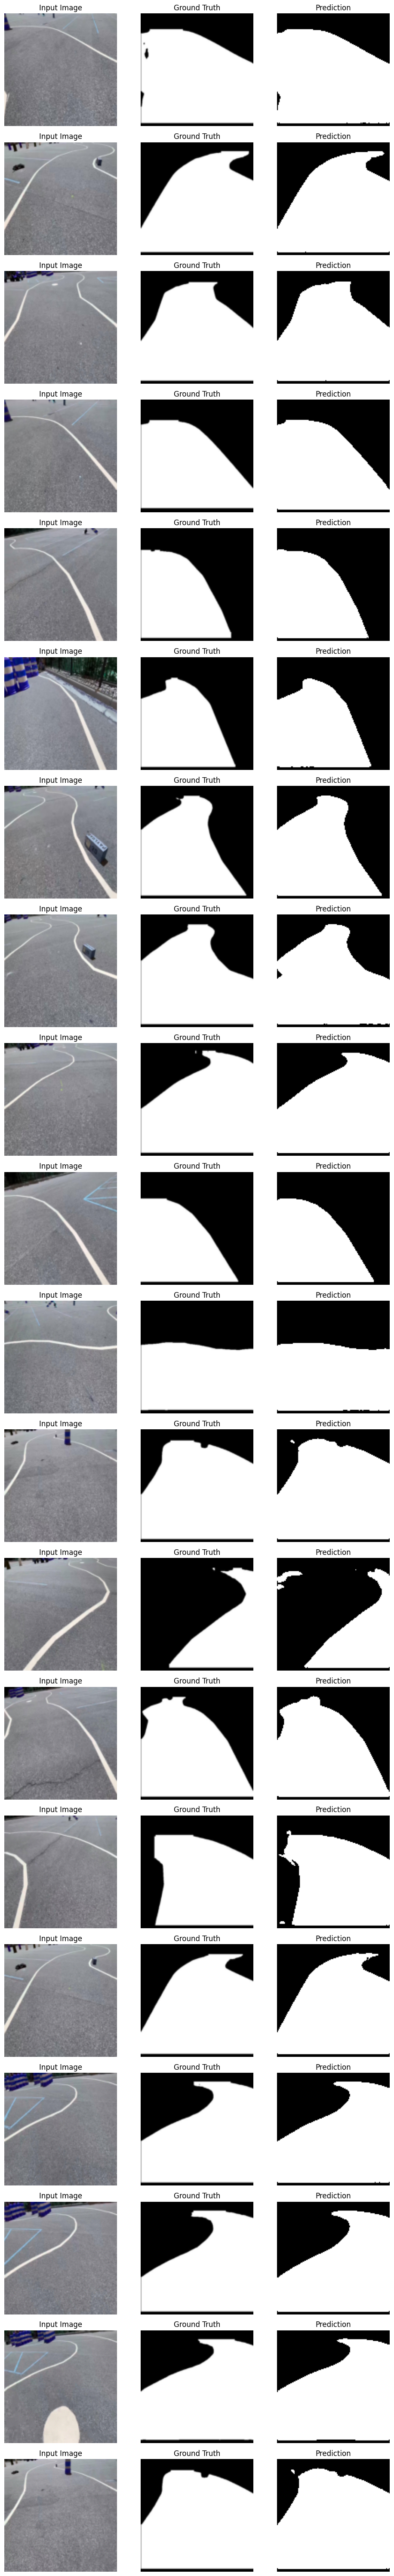

In [36]:
import random

# Switch to eval mode
model.eval()

# Get a few random samples from validation set
n_samples = 20
indices = random.sample(range(len(val_set)), n_samples)
samples = [val_set[i] for i in indices]

fig, axes = plt.subplots(n_samples, 3, figsize=(10, n_samples * 3))

for i, (img, mask) in enumerate(samples):
    img = img.unsqueeze(0).to(device)   # add batch dimension
    with torch.no_grad():
        pred = model(img)
        pred = torch.sigmoid(pred)          # convert logits → probability
        pred = (pred > 0.5).float()         # threshold → binary mask

    # Move tensors to CPU for plotting
    img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()

    # Plot: input, ground truth, prediction
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_np, cmap="gray")
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_np, cmap="gray")
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()